## Forex CNY - RUB

In [ ]:
!pip install alpha_vantage
!pip install --upgrade statsmodels
!pip install prophet

In [ ]:
import os 
import numpy as np
import pandas as pd
from datetime import datetime
from alpha_vantage.foreignexchange import ForeignExchange
from pprint import pprint

In [ ]:
import warnings
warnings.filterwarnings('ignore')

## The google drive mounting is for using local library

In [ ]:
try:
    # Mount your google drive in google colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Insert the directory to syspath
    import sys
    sys.path.insert(0, '/content/drive/MyDrive/Colab Notebooks')
except:
    pass

In [ ]:
from time_series_utils import timeseries_evaluation_metrics_func,\
                          create_proph_train_test, find_best_Prophet_model,\
                          find_best_ETS_model, find_best_ARIMA_model, find_best_SARIMAX_model,\
                          load_hyperparam, save_hyperparam

## Forex CNY RUB Time Series

In [ ]:
suffix = 'forex_CNY_RUB'

In [ ]:
try:
    with open('drive/MyDrive/ALPHAVANTAGE_API_KEY.txt') as f:
        api_key = f.readline()
except:
    api_key = os.environ.get('ALPHAVANTAGE_API_KEY')

In [ ]:
cc = ForeignExchange(key=api_key)

In [ ]:
data, _ = cc.get_currency_exchange_daily('CNY', 'RUB', outputsize='full')

In [ ]:
df = pd.DataFrame(data).transpose()
df.columns = ['open', 'high', 'low', 'close']

In [ ]:
df.shape

(1947, 4)

In [ ]:
df.columns

Index(['open', 'high', 'low', 'close'], dtype='object')

In [ ]:
df.head(), df.tail()

(                open      high       low     close
 2022-05-11  10.40750  10.40750  10.17400  10.17400
 2022-05-10  10.24760  10.41370  10.15620  10.40750
 2022-05-09   9.91910  10.53060   9.91530  10.41360
 2022-05-06   9.73730  10.24390   9.55820  10.18760
 2022-05-05   9.98210   9.98940   9.62200   9.79860,
                open     high      low    close
 2014-11-28  7.90970  8.20860  7.89940  8.17980
 2014-11-27  7.66500  7.99430  7.62520  7.97980
 2014-11-26  7.54140  7.72020  7.49720  7.66500
 2014-11-25  7.31300  7.54360  7.28120  7.54350
 2014-11-24  7.48030  7.48030  7.23860  7.31300)

In [ ]:
# The dataframe is desendent we need to reverse it
df = df[::-1]
df.head(), df.tail()

(               open     high      low    close
 2014-11-24  7.48030  7.48030  7.23860  7.31300
 2014-11-25  7.31300  7.54360  7.28120  7.54350
 2014-11-26  7.54140  7.72020  7.49720  7.66500
 2014-11-27  7.66500  7.99430  7.62520  7.97980
 2014-11-28  7.90970  8.20860  7.89940  8.17980,
                 open      high       low     close
 2022-05-05   9.98210   9.98940   9.62200   9.79860
 2022-05-06   9.73730  10.24390   9.55820  10.18760
 2022-05-09   9.91910  10.53060   9.91530  10.41360
 2022-05-10  10.24760  10.41370  10.15620  10.40750
 2022-05-11  10.40750  10.40750  10.17400  10.17400)

In [ ]:
df = df.reset_index().rename(columns={'index': 'Date'})
df.Date = pd.to_datetime(df.Date)
df = df.set_index('Date')
df = df.asfreq('B') # business day / working day 

In [ ]:
df

open      high       low     close
Date                                              
2014-11-24   7.48030   7.48030   7.23860   7.31300
2014-11-25   7.31300   7.54360   7.28120   7.54350
2014-11-26   7.54140   7.72020   7.49720   7.66500
2014-11-27   7.66500   7.99430   7.62520   7.97980
2014-11-28   7.90970   8.20860   7.89940   8.17980
...              ...       ...       ...       ...
2022-05-05   9.98210   9.98940   9.62200   9.79860
2022-05-06   9.73730  10.24390   9.55820  10.18760
2022-05-09   9.91910  10.53060   9.91530  10.41360
2022-05-10  10.24760  10.41370  10.15620  10.40750
2022-05-11  10.40750  10.40750  10.17400  10.17400

[1948 rows x 4 columns]

In [ ]:
df = df[['close']]
df.columns = ['CNY/RUB']

In [ ]:
df['CNY/RUB'] = df['CNY/RUB'].astype('float')
df.dtypes

CNY/RUB    float64
dtype: object

In [ ]:
# change to weekly cumulative 
dfw = df.resample('W').sum()

In [ ]:
dfw.head()

CNY/RUB
Date               
2014-11-30  38.6811
2014-12-07  43.2048
2014-12-14  44.6943
2014-12-21  50.0169
2014-12-28  43.3334

In [ ]:
dfw.index

DatetimeIndex(['2014-11-30', '2014-12-07', '2014-12-14', '2014-12-21',
               '2014-12-28', '2015-01-04', '2015-01-11', '2015-01-18',
               '2015-01-25', '2015-02-01',
               ...
               '2022-03-13', '2022-03-20', '2022-03-27', '2022-04-03',
               '2022-04-10', '2022-04-17', '2022-04-24', '2022-05-01',
               '2022-05-08', '2022-05-15'],
              dtype='datetime64[ns]', name='Date', length=390, freq='W-SUN')

In [ ]:
dfw.head()

CNY/RUB
Date               
2014-11-30  38.6811
2014-12-07  43.2048
2014-12-14  44.6943
2014-12-21  50.0169
2014-12-28  43.3334

In [ ]:
dfw.tail()

CNY/RUB
Date               
2022-04-17  64.9807
2022-04-24  62.6591
2022-05-01  55.8318
2022-05-08  50.8935
2022-05-15  30.9951

<AxesSubplot:xlabel='Date'>

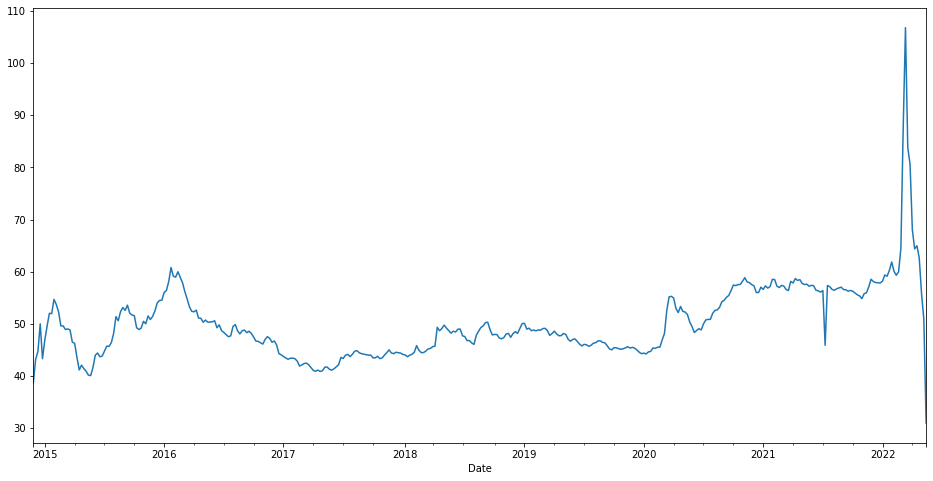

In [ ]:
dfw['CNY/RUB'].plot(figsize=(16,8))

In [ ]:
from datetime import datetime, timedelta
train_dataset_end = datetime(2022,2,28)
test_dataset_end = datetime(2022,5,10)

In [ ]:
train_data = dfw[:train_dataset_end]
test_data = dfw[train_dataset_end+timedelta(days=1):test_dataset_end]

In [ ]:
prediction_length = len(test_data)

Save train and test data to filesystem

In [ ]:
train_data_filename = f'train_data_{suffix}.csv'
test_data_filename = f'test_data_{suffix}.csv'

In [ ]:
train_data.to_csv(train_data_filename, encoding='utf-8')
test_data.to_csv(test_data_filename, encoding='utf-8')

Reload train and test data from filesytem

In [ ]:
train_data = pd.read_csv(train_data_filename, parse_dates=['Date'], index_col='Date')
test_data = pd.read_csv(test_data_filename, parse_dates=['Date'], index_col='Date')

In [ ]:
train2_data = train_data[:-(prediction_length)]
val_data = train_data[-(prediction_length):]

In [ ]:
prediction_length, len(val_data), len(train_data), len(train2_data)

(10, 10, 379, 369)

In [ ]:
val_data.tail()

CNY/RUB
Date               
2022-01-30  61.8815
2022-02-06  60.0933
2022-02-13  59.3318
2022-02-20  59.9988
2022-02-27  64.4489

In [ ]:
val_data.shape

(10, 1)

In [ ]:
val_data.head()

CNY/RUB
Date               
2021-12-26  57.8505
2022-01-02  58.2160
2022-01-09  59.3834
2022-01-16  59.1500
2022-01-23  60.2942

In [ ]:
# Value Columns to be used in all models tuning
value_col = 'CNY/RUB'

In [ ]:
# freq and date_col for Prophet
ph_freq='W' # weekly cumulative
ph_date_col='Date'

## Holt Winters Exponential Smoothing (ETS)

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
best_ETS_RMSE_model, best_RMSE, best_ETS_RMSE_params, best_ETS_WMAPE_model, best_WMAPE, best_ETS_WMAPE_params\
 = find_best_ETS_model(train2_data, val_data, value_col=value_col, seasonal_periods=[13,52])

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packa

In [ ]:
best_WMAPE, best_ETS_WMAPE_params

(0.017727928228517698, ('add', 'add', 52))

In [ ]:
best_RMSE, best_ETS_RMSE_params

(1.7974199549247116, ('add', 'mul', 52))

24.805195629289507, ('mul', 'add', 52)

We forward forecast after we found the best hyperparam with train2 and validation data.

In [ ]:
trend, seasonal, seasonal_period = best_ETS_RMSE_params

ETS_model_updated = ExponentialSmoothing(train_data[value_col], trend=trend, seasonal=seasonal,\
                                         seasonal_periods=seasonal_period).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [ ]:
test_pred_ETS = ETS_model_updated.forecast(len(test_data))
test_pred_ETS

2022-03-06    63.741728
2022-03-13    63.958552
2022-03-20    63.606995
2022-03-27    63.966824
2022-04-03    63.509082
2022-04-10    63.141292
2022-04-17    62.828916
2022-04-24    62.946258
2022-05-01    62.882790
2022-05-08    62.493137
Freq: W-SUN, dtype: float64

In [ ]:
test_data['Predicted_ETS'] = test_pred_ETS

<AxesSubplot:xlabel='Date'>

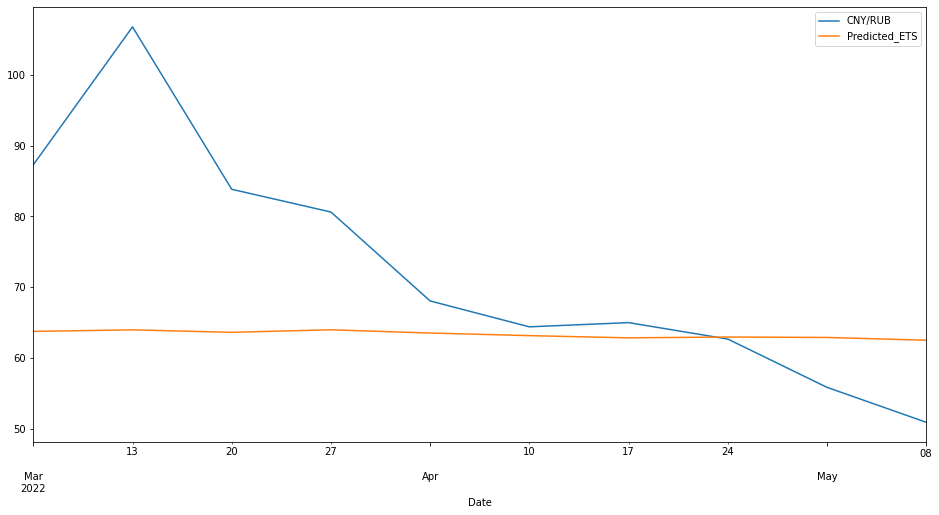

In [ ]:
test_data[[value_col, 'Predicted_ETS']].plot(figsize=(16,8))

## ARIMA model

In [ ]:
## create an ARIMA model
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
arima_model_filename = f"arima_{suffix}_hyper_params"

In [ ]:
# run once then comment out 
# best_params = (0, 2, 0)
# save_hyperparam(arima_model_filename, best_params)

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(arima_model_filename)
except:
    pass 

In [ ]:
# # to force update on hyperparameters
# best_params = None 

We search for best hyperparameters with train2 data and val data.

In [ ]:
best_ARIMA_RMSE_model, best_RMSE, best_pdq_RMSE, best_ARIMA_WMAPE_model, best_WMAPE, best_pdq_WMAPE\
 = find_best_ARIMA_model(train2_data, val_data, value_col=value_col, best_params=best_params)

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packa

In [ ]:
best_pdq_WMAPE, best_WMAPE

((0, 1, 8), 0.030109558532484156)

In [ ]:
best_pdq_RMSE, best_RMSE

((0, 1, 8), 2.4905333457109893)

In [ ]:
# save hyperparam to file 
save_hyperparam(arima_model_filename, best_pdq_RMSE)

((0, 2, 0), 19.210491410688945)

We update the model with new data (whole train data).

In [ ]:
model_ARIMA = ARIMA(train_data[value_col], order=best_pdq_RMSE).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


In [ ]:
test_pred_arima = model_ARIMA.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
test_data['Predicted_ARIMA'] = test_pred_arima

<AxesSubplot:xlabel='Date'>

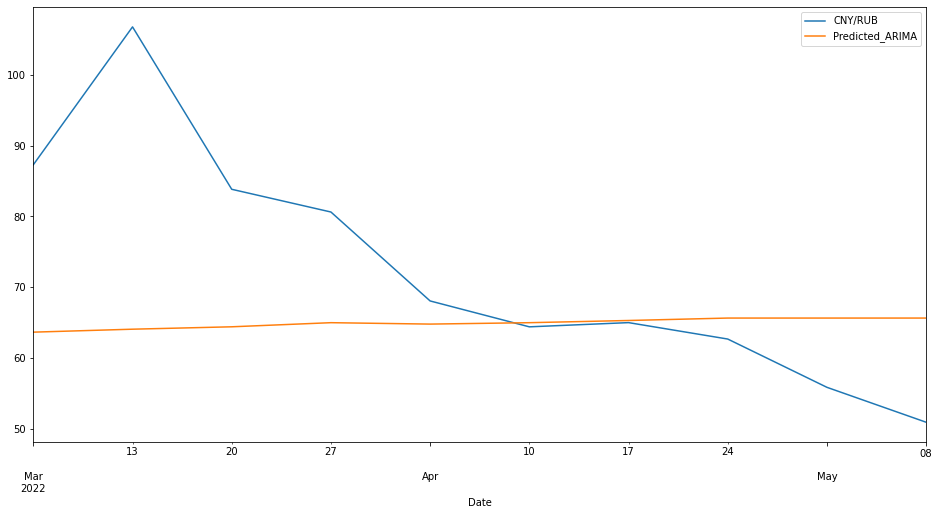

In [ ]:
test_data[[value_col, 'Predicted_ARIMA']].plot(figsize=(16,8))

### SARIMA Model

In [ ]:
# create a SARIMAX model 
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
sarimax_model_filename = f"sarimax_{suffix}_hyper_params"

In [ ]:
# run once then comment out 
# best_params = (0, 0, 0, 52)
# save_hyperparam(sarimax_model_filename, best_params)

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(sarimax_model_filename)
except:
    pass 

In [ ]:
# we get best pdq from ARIMA (=best_pdq) and seaonal_period from ETS best params
seasonal_period = best_ETS_WMAPE_params[2]

In [ ]:
# # we force the hyperparameter update 
# best_params = None 

We find hyperparams with train2 and validation data. 

In [ ]:
best_SARIMAX_model, best_RMSE, best_PDQS = find_best_SARIMAX_model(train2_data, val_data, best_pdq_RMSE, \
                                                                  value_col=value_col, season_period=seasonal_period,\
                                                                   best_params=best_params)

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67370D+00    |proj g|=  2.56095D-01

At iterate    5    f=  1.64587D+00    |proj g|=  5.06783D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      8     10      1     0     0   1.907D-06   1.646D+00
  F =   1.6458703184062511     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67481D+00    |proj g|=  2.57999D-01

At iterate    5    f=  1.64466D+00    |proj g|=  1.38948D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      9     11      1     0     0   6.035D-06   1.645D+00
  F =   1.6446539527738515     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67370D+00    |proj g|=  2.56095D-01


 This problem is unconstrained.



At iterate    5    f=  1.64409D+00    |proj g|=  2.31526D-03

At iterate   10    f=  1.64407D+00    |proj g|=  2.67670D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     10     12      1     0     0   2.677D-06   1.644D+00
  F =   1.6440720006333720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57089D+00    |proj g|=  9.92761D-02

At iterate    5    f=  1.56117D+00    |proj g|=  1.31242D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      7      9      1     0     0   4.828D-06   1.561D+00
  F =   1.5611708881308854     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53249D+00    |proj g|=  5.88729D-02


 This problem is unconstrained.



At iterate    5    f=  1.52104D+00    |proj g|=  2.01400D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      9     11      1     0     0   6.212D-06   1.521D+00
  F =   1.5210363253666948     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57089D+00    |proj g|=  1.79223D-01

At iterate    5    f=  1.52104D+00    |proj g|=  1.42650D-03

At iterate   10    f=  1.52103D+00    |proj g|=  1.09585D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     11     13      1     0     0   4.718D-06   1.521D+00
  F =   1.5210294831928386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67234D+00    |proj g|=  2.53349D-01

At iterate    5    f=  1.64476D+00    |proj g|=  6.06254D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      9     11      1     0     0   5.307D-06   1.645D+00
  F =   1.6447637607532899     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67781D+00    |proj g|=  2.62798D-01


 This problem is unconstrained.



At iterate    5    f=  1.64457D+00    |proj g|=  1.21937D-03

At iterate   10    f=  1.64445D+00    |proj g|=  5.94956D-03

At iterate   15    f=  1.64305D+00    |proj g|=  5.49594D-03

At iterate   20    f=  1.64274D+00    |proj g|=  5.84381D-04

At iterate   25    f=  1.64274D+00    |proj g|=  2.61889D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     25     28      1     0     0   2.619D-05   1.643D+00
  F =   1.6427353933329356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69035D+00    |proj g|=  2.81224D-01


 This problem is unconstrained.



At iterate    5    f=  1.64403D+00    |proj g|=  2.99833D-03

At iterate   10    f=  1.64398D+00    |proj g|=  2.41620D-03

At iterate   15    f=  1.64280D+00    |proj g|=  4.28453D-03

At iterate   20    f=  1.64273D+00    |proj g|=  2.71247D-03

At iterate   25    f=  1.64271D+00    |proj g|=  1.19398D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     29     34      1     0     0   9.827D-06   1.643D+00
  F =   1.6427109393603712     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53644D+00    |proj g|=  5.89598D-02

At iterate    5    f=  1.52908D+00    |proj g|=  1.06168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      8     10      1     0     0   7.300D-06   1.529D+00
  F =   1.5290826560570037     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57519D+00    |proj g|=  7.26427D-02


 This problem is unconstrained.



At iterate    5    f=  1.54122D+00    |proj g|=  2.13128D-02

At iterate   10    f=  1.52107D+00    |proj g|=  3.94226D-03

At iterate   15    f=  1.52103D+00    |proj g|=  4.70664D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     15     17      1     0     0   4.707D-06   1.521D+00
  F =   1.5210303325892029     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57089D+00    |proj g|=  1.79223D-01


 This problem is unconstrained.



At iterate    5    f=  1.52104D+00    |proj g|=  2.35644D-03

At iterate   10    f=  1.52102D+00    |proj g|=  3.44768D-04

At iterate   15    f=  1.52089D+00    |proj g|=  1.80682D-02

At iterate   20    f=  1.51944D+00    |proj g|=  4.85364D-03

At iterate   25    f=  1.51912D+00    |proj g|=  5.60084D-03

At iterate   30    f=  1.51906D+00    |proj g|=  4.67581D-04

At iterate   35    f=  1.51898D+00    |proj g|=  1.03761D-03

At iterate   40    f=  1.51896D+00    |proj g|=  7.49361D-04

At iterate   45    f=  1.51896D+00    |proj g|=  2.67824D-04


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.51896D+00    |proj g|=  1.05344D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     50     59      1     0     0   1.053D-04   1.519D+00
  F =   1.5189585686836227     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67676D+00    |proj g|=  2.60898D-01


 This problem is unconstrained.



At iterate    5    f=  1.64431D+00    |proj g|=  1.01067D-03

At iterate   10    f=  1.64431D+00    |proj g|=  3.25446D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11     10     12      1     0     0   3.254D-06   1.644D+00
  F =   1.6443073490208751     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67725D+00    |proj g|=  2.61015D-01


 This problem is unconstrained.



At iterate    5    f=  1.64420D+00    |proj g|=  8.79729D-04

At iterate   10    f=  1.64416D+00    |proj g|=  3.39217D-03

At iterate   15    f=  1.64319D+00    |proj g|=  1.29410D-02

At iterate   20    f=  1.64273D+00    |proj g|=  1.28860D-03

At iterate   25    f=  1.64271D+00    |proj g|=  1.88227D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     29     33      1     0     0   4.975D-06   1.643D+00
  F =   1.6427108336103886     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68853D+00    |proj g|=  2.75380D-01


 This problem is unconstrained.



At iterate    5    f=  1.64430D+00    |proj g|=  2.20362D-03

At iterate   10    f=  1.64388D+00    |proj g|=  1.29620D-02

At iterate   15    f=  1.64275D+00    |proj g|=  1.26697D-03

At iterate   20    f=  1.64273D+00    |proj g|=  4.68392D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     22     25      1     0     0   3.249D-06   1.643D+00
  F =   1.6427347430828187     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53081D+00    |proj g|=  7.38147D-02


 This problem is unconstrained.



At iterate    5    f=  1.52065D+00    |proj g|=  5.98259D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   11      9     11      1     0     0   2.577D-05   1.521D+00
  F =   1.5206444338491492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55387D+00    |proj g|=  1.05354D-01


 This problem is unconstrained.



At iterate    5    f=  1.52074D+00    |proj g|=  2.33085D-03

At iterate   10    f=  1.52067D+00    |proj g|=  2.13264D-03

At iterate   15    f=  1.52057D+00    |proj g|=  2.97639D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     19     21      1     0     0   6.624D-06   1.521D+00
  F =   1.5205727142614858     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57089D+00    |proj g|=  1.79223D-01


 This problem is unconstrained.



At iterate    5    f=  1.52057D+00    |proj g|=  1.33807D-03

At iterate   10    f=  1.52042D+00    |proj g|=  5.48927D-03

At iterate   15    f=  1.51915D+00    |proj g|=  3.03288D-03

At iterate   20    f=  1.51858D+00    |proj g|=  1.63536D-03

At iterate   25    f=  1.51850D+00    |proj g|=  8.67310D-04

At iterate   30    f=  1.51847D+00    |proj g|=  2.30746D-03

At iterate   35    f=  1.51845D+00    |proj g|=  7.91099D-04

At iterate   40    f=  1.51844D+00    |proj g|=  1.87905D-04

At iterate   45    f=  1.51844D+00    |proj g|=  5.60689D-04


/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  1.51844D+00    |proj g|=  5.18146D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     50     54      1     0     0   5.181D-05   1.518D+00
  F =   1.5184359457011094     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [ ]:
best_PDQS

(1, 1, 0, 52)

(0, 0, 0, 52)

In [ ]:
# save best hyperparam to file 
save_hyperparam(sarimax_model_filename, best_PDQS)

We train model with new data (full train data).

In [ ]:
model_SARIMAX = SARIMAX(train_data[value_col], order=best_pdq_RMSE, seasonal_order=best_PDQS).fit()

/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/wismin/miniconda3/envs/timeseries/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54264D+00    |proj g|=  6.44065D-02


 This problem is unconstrained.



At iterate    5    f=  1.53556D+00    |proj g|=  1.32563D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      8     10      1     0     0   8.518D-06   1.536D+00
  F =   1.5355583282852527     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


In [ ]:
test_pred_SARIMAX = model_SARIMAX.predict(start=test_data.index[0], end=test_data.index[-1])

In [ ]:
test_data['Predicted_SARIMAX'] = test_pred_SARIMAX

<AxesSubplot:xlabel='Date'>

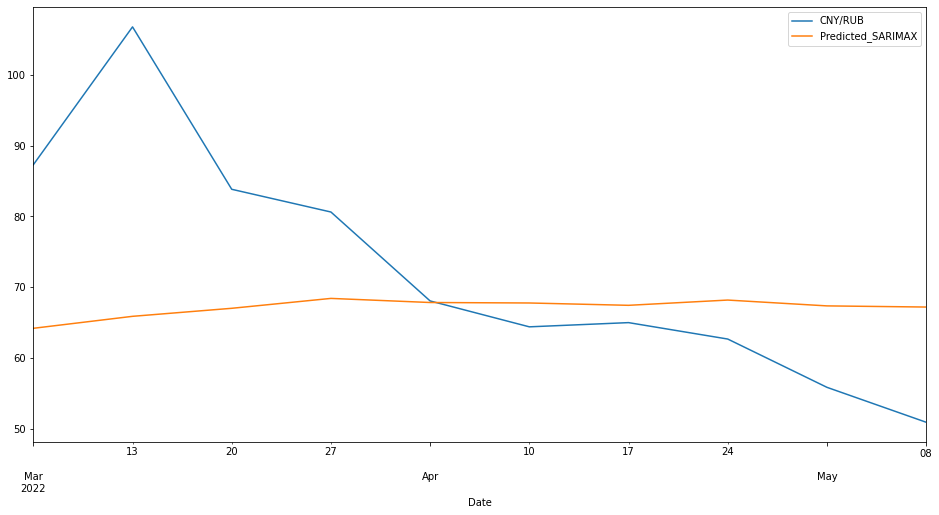

In [ ]:
test_data[[value_col, 'Predicted_SARIMAX']].plot(figsize=(16,8))

### Prophet

In [ ]:
from prophet import Prophet

In [ ]:
proph_train2, proph_val = create_proph_train_test(train2_data, val_data, date_col=ph_date_col, value_col=value_col)
proph_train, proph_test = create_proph_train_test(train_data, test_data, date_col=ph_date_col, value_col=value_col)

In [ ]:
prophet_model_filename = f"prophet_{suffix}_hyper_params"

In [ ]:
# run once then comment out 
# best_params = (0.8, 0.05, 2, 'multiplicative')
# save_hyperparam(prophet_model_filename, best_params)

In [ ]:
best_params = None 
try:
    best_params = load_hyperparam(prophet_model_filename)
except:
    pass 

In [ ]:
# # force hyperparameter tuning 
# best_params = None 

Find the best hyperparameters with train2 and validation data. 

In [ ]:
best_Prophet_RMSE_model, best_RMSE, best_Prophet_RMSE_params,\
best_Prophet_WMAPE_model, best_WMAPE, best_Prophet_WMAPE_params\
  = find_best_Prophet_model(
      proph_train2, proph_val, val_data, value_col=value_col,freq=ph_freq, best_params=best_params)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.512      0.013964       109.959      0.2967      0.9973      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       904.534   0.000462803       126.149   6.056e-06       0.001      232  LS failed, Hessian reset 
     199       904.567   9.29898e-06       78.3808      0.1265           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       908.467    0.00150561        174.64   1.698e-05       0.001      433  LS failed, Hessian reset 
     299       909.076   0.000213091       94.8691      0.3818      0.3818      450   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       909.853   0.000147739       74.5881           1           1      586   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.33628528434140215
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        902.36     0.0317697       109.288      0.5061      0.5061      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       909.529    0.00296876       67.4567           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       910.558    0.00251316       120.251   2.553e-05       0.001      378  LS failed, Hessian reset 
     299        911.03   0.000564824       91.0783           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       912.017   0.000350862       121.703   3.219e-06       0.001      577  LS failed, Hessian reset 
     399       912.214   0.000859652       74.3386      0.5357    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3881624391809851
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       897.035     0.0300284       207.999           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180        905.11   0.000307755       80.7326   1.944e-06       0.001      268  LS failed, Hessian reset 
     199       905.503    0.00255766       80.0736           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       908.575     0.0139146       137.422           1           1      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       909.052   0.000591553       155.257   7.777e-06       0.001      465  LS failed, Hessian reset 
     392       909.955   5.13474e-05       77.9481   7.227e-07     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3400592584147773
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       897.458    0.00351626       77.7515       0.247           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       905.989   0.000306093       79.5118      0.4928      0.4928      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       910.472   0.000244913        63.535      0.4853      0.4853      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     324       910.873   0.000239897       88.6066   2.271e-06       0.001      438  LS failed, Hessian reset 
     399       911.148    0.00610591       105.504      0.3782           1      527   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.38955576503137457
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       897.939     0.0306247       415.654      0.6744      0.6744      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159        904.16   0.000466606       138.133   4.704e-06       0.001      244  LS failed, Hessian reset 
     199       904.651   0.000721077       90.0697      0.3759           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       909.394   0.000986334        80.954           1           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       909.861   0.000477707       145.491   5.205e-06       0.001      475  LS failed, Hessian reset 
     379       909.958   5.75973e-08       75.1931           1    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.33468611517736974
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       897.153    0.00290691       100.057      0.4306      0.4306      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111        901.65    0.00050526       146.656   3.799e-06       0.001      169  LS failed, Hessian reset 
     199       908.547     0.0150783       130.511           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       911.028   0.000594965       94.6895   8.371e-06       0.001      386  LS failed, Hessian reset 
     273       911.271   0.000340468       135.111   2.831e-06       0.001      459  LS failed, Hessian reset 
     299       911.336   0.000123036       84.2464       2.453      0.2453      494   
    Iter      log prob        ||dx||      ||gra

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.39904852958542286
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       945.524     0.0025546       155.523      0.2065      0.7549      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       962.689   0.000942754       134.156       0.285           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       963.796   0.000222629       65.8579   1.122e-06       0.001      322  LS failed, Hessian reset 
     257       964.792   0.000182204       72.0442   3.275e-06       0.001      386  LS failed, Hessian reset 
     299       966.411    0.00168715       453.263      0.5856      0.5856      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     391       969.353   0.000267395       85.9292   5.919e-06    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2505971745210113
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       956.012    0.00491245        262.56           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       964.689      0.013384       150.488           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       971.559   0.000797411       41.0556           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     361       972.429   0.000183265        77.825    3.98e-06       0.001      477  LS failed, Hessian reset 
     399       972.724   0.000619416       27.2574      0.4228           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2765294440822463
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       941.263    0.00771227        131.19      0.3655      0.3655      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188        960.89   0.000228037       91.9945   3.668e-06       0.001      256  LS failed, Hessian reset 
     199       961.416    0.00244816       66.2137           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        967.88     0.0136997       130.213           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       969.361    0.00150362       60.9006           1           1      524   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.24641951430873438
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       948.645      0.025475       140.793           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       964.786     0.0655213       166.842           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278        970.76   0.000228688       107.642   2.196e-06       0.001      383  LS failed, Hessian reset 
     299       971.246    0.00102723        85.558           1           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     386       972.951   0.000615883       146.479   1.154e-05       0.001      559  LS failed, Hessian reset 
     399       973.208    0.00311406       48.1271      0.8984    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2720466140103492
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       946.471     0.0356856       105.023           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       962.792     0.0353163        363.62           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     294       967.121   0.000168981       71.6981   1.247e-06       0.001      400  LS failed, Hessian reset 
     299       967.362     0.0046674       85.3164           1           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       968.895   0.000274016       101.509    5.49e-06       0.001      540  LS failed, Hessian reset 
     399       969.572   0.000261874       60.6405      0.4966     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.25377762257019365
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        951.15     0.0101674       101.603           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       966.229    0.00684092       95.3798      0.5494      0.5494      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       970.302    0.00203817       88.0844           1           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       972.845    0.00196089       92.4151           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     471       973.318   0.000365871       56.8545   9.192e-06       0.001      634  LS failed, Hessian reset

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2728074560782251
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1001.74     0.0127754       125.081           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1024.29    0.00265251       147.968       0.373       0.373      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1041.41    0.00672665       224.765           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1047.64     0.0149126       153.293      0.0453      0.9203      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1052.54    0.00604831       73.9409           1           1      569   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2535855491537239
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1004.9    0.00116394       198.802      0.6788      0.6788      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1036.48    0.00271442       40.1686           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1048.44    0.00773731       55.1809           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1053.64     0.0159851       170.728      0.2265           1      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1058.81    0.00156945        87.359      0.3826           1      583   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2592803667898017
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1007.04     0.0126223       83.9176           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1028.3     0.0201224       371.005           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1040.5     0.0106686       130.705      0.3904      0.3904      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1047.89    0.00192449       54.3591           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1053.26    0.00148802        27.244       0.842       0.842      579   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.25316079257329505
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1013.62     0.0392268       226.349           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1037.04     0.0380506        604.52      0.4767           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1048.33    0.00505538       61.4328           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1053.73    0.00231934       34.9017           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1056.42    0.00111495       38.3539           1           1      577   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2593332490254657
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1005.11     0.0758708       664.801           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1036.11    0.00627849       68.5488           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1041.23    0.00130027       72.6483      0.5292      0.5292      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1048.72   0.000693389        109.41      0.6895      0.6895      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1052.72     0.0246432       89.6037           1           1      574   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.254567130407599
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1008.61     0.0141056       126.448           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1034.73    0.00706569        398.95      0.2675      0.2675      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1045.43     0.0149201       255.818           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1052.97     0.0140336       417.596      0.7893      0.7893      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1055.84     0.0231598       61.7977           1           1      573   
    Iter      log prob  

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2595676332557094
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1017.77     0.0154427       266.323      0.9132      0.9132      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1052.35     0.0251337         289.1      0.8137      0.8137      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1063.88    0.00516887       52.4585           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1073.85     0.0319135       216.931      0.6308      0.6308      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1077.91     0.0145237       129.858           1           1      567   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2443384360892454
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1022.75    0.00928506       248.265           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1058.41     0.0101547       82.4711      0.5143      0.5143      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1069.25     0.0211319       282.691           1           1      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1078.44    0.00404901       25.6329           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1086.23    0.00449118       88.7273      0.3224      0.9914      579   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.25990591134378827
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1018.89      0.058215       111.584           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1054.92      0.016196       84.3707           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1060.65     0.0162895       86.3237           1           1      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1066.63    0.00345717       71.4134           1           1      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1072.98    0.00665352       42.3635           1           1      573   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.24401622940602047
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1011.53      0.032344       311.079      0.3128           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1043.87     0.0100459       370.235           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1057.57    0.00320768       37.7968       1.915      0.1915      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1073.85    0.00725161       286.156      0.5316      0.5316      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1079.1     0.0119365       129.523       0.447           1      592   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2591621294575584
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1016.2     0.0421161       446.525      0.4508           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1051.69     0.0250534       313.165      0.2261           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1058.71     0.0176547       307.911           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1064.5     0.0183891       104.963      0.9315      0.9315      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1073.56     0.0597695       78.8394           1           1      579   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.24370191580440143
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1024.65     0.0788059       243.569           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1054.74    0.00299949        197.88           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1064.56     0.0186542       305.494      0.5001           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1074.52    0.00142021       77.5306           1           1      475   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1080.62     0.0025418       114.102      0.4583      0.4583      590   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.259729532146064
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       895.741    0.00477646       135.694      0.9459      0.9459      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       908.398    0.00480624       123.889      0.7554      0.7554      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       909.502    0.00105474        120.45    1.47e-05       0.001      327  LS failed, Hessian reset 
     297       910.187   0.000312951       103.349   4.474e-06       0.001      456  LS failed, Hessian reset 
     299       910.195   0.000155655       72.2367           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       910.549   4.50497e-05       81.1869      0.5361      

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.24040020098109718
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       887.228   0.000384535       96.6439   4.044e-06       0.001      100  LS failed, Hessian reset 
      99       902.477     0.0347831       112.655           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163        910.29   0.000262066       87.6782   2.454e-06       0.001      320  LS failed, Hessian reset 
     199       911.831   0.000752959       115.702           1           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       912.235   0.000702318       195.439    7.79e-06       0.001      429  LS failed, Hessian reset 
     299       912.497    0.00108996       104.469   1.245e-05       0.001      561  LS failed, Hessian reset 
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.25903649375940674
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.312     0.0263626       131.793           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       903.792   0.000403854       128.971   2.626e-06       0.001      177  LS failed, Hessian reset 
     199       908.635    0.00499487       103.626           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       909.406    0.00127534       155.117   1.409e-05       0.001      332  LS failed, Hessian reset 
     290       910.583   0.000134259       70.7636   2.404e-06       0.001      518  LS failed, Hessian reset 
     299       910.663   0.000841418       88.6553      0.5551      0.5551      528   
    Iter      log prob        ||dx||      ||gra

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.24273799591980966
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.479    0.00395099       88.5793      0.8306      0.8306      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       909.438     0.0166887       238.055           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259        912.26    0.00731493       420.103   7.315e-05       0.001      361  LS failed, Hessian reset 
     299       913.157   7.99125e-05       60.5929           1           1      416   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     359       913.163    3.9428e-08       60.8968     0.07278           1      508   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.2752857052300585
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.706     0.0156325       94.9186           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       906.271     0.0369045        377.73      0.2431           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       911.052   0.000169875       70.3874   1.666e-06       0.001      384  LS failed, Hessian reset 
     299       911.076   6.97229e-06       59.7052         0.7         0.7      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     378       911.081   5.97549e-08       52.3621      0.3764      0.3764      530   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is b

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.24602201450929856
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       901.794   0.000889109       180.212   7.852e-06       0.001      140  LS failed, Hessian reset 
      99       903.701    0.00391857       69.8672      0.8735      0.8735      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        912.38    0.00047462       79.3962      0.2302      0.2302      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       913.159     0.0010815       204.743   1.678e-05       0.001      384  LS failed, Hessian reset 
     299       913.269   0.000403961         88.48           1           1      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       913.275   9.96773e-05       67.3946   1.113e-06    

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.26957944919155385
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       959.622     0.0659591        522.79           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       972.185    0.00705073       91.2507       1.446      0.1446      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       977.216     0.0123078       181.688           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        982.81    0.00184698        72.365           1           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     474       983.467   0.000113962       44.8421   1.188e-06       0.001      624  LS failed, Hessian reset

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3513581180627433
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       956.567     0.0340234       180.814        1.56       0.156      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       974.765    0.00425112       227.027      0.5821      0.5821      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       978.349    0.00173244       97.4573      0.9934      0.9934      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       982.571     0.0206804       48.9179           1           1      502   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     423       983.804   0.000100581       44.7195   1.338e-06       0.001      593  LS failed, Hessian reset 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.31012226338288
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         959.5     0.0126222       71.5956           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       973.241     0.0420638       366.367      0.1585           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       979.337    0.00109066       43.1628      0.7591      0.7591      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306       979.446   0.000135196       59.5599   2.902e-06       0.001      416  LS failed, Hessian reset 
     399       982.836    0.00229682       90.4656      0.5779      0.5779      532   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3515345794946212
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       962.245    0.00411962       85.1811           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       975.268     0.0191968       391.301           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209        976.09   0.000295272       127.262   1.494e-06       0.001      292  LS failed, Hessian reset 
     268       978.037    0.00012004        55.718   2.215e-06       0.001      397  LS failed, Hessian reset 
     299       979.044   0.000178122       78.6938   3.807e-06       0.001      473  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       980.144   0.000123381       

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.322786520988755
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        964.23    0.00553169       299.289      0.2574      0.2574      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       974.069    0.00802066        164.47       0.452       0.452      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       978.419    0.00607721       76.5479           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       982.473    0.00611103       94.7811      0.1741           1      482   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     496       983.724   0.000149252       45.4976   1.059e-06       0.001      655  LS failed, Hessian reset 


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3521203964418807
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       963.683     0.0413395       128.759           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       974.621   0.000221208       87.0396   4.323e-06       0.001      254  LS failed, Hessian reset 
     199       975.756     0.0193485       223.957          10           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       977.217   0.000178862       41.4344   1.108e-06       0.001      371  LS failed, Hessian reset 
     299       978.484    0.00120106       35.7289           1           1      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       985.245   0.000494282       31.8377      0.3559     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3083947066396936
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1022.03    0.00369209       116.684           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1045.42      0.021969       144.921           1           1      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1056.94    0.00101468       35.5502           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1062.99    0.00256607       27.5653           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1064.22    0.00267843       107.814      0.2519           1      571   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.39885698493344224
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1024.38    0.00995475       84.2611           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1049.07    0.00440554       51.1538           1           1      228   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1056.5   0.000119231       38.4002           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1063.94    0.00226426       18.9197      0.8242      0.8242      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1065.19    0.00606077       73.0453           1           1      586   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.33756336751347693
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1022.13    0.00778764       89.2718           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1048.77    0.00277899       48.6346      0.5769      0.5769      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1056.52    0.00265322       38.8134           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1060.03    0.00674388       38.1074           1           1      454   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1062.8   0.000373602       53.3227      0.5639      0.5639      578   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.39739285824745907
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1030.72     0.0106632        203.56           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1051.82    0.00491116       72.6935      0.4615      0.4615      238   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1060.57    0.00592718       66.0399      0.7814      0.7814      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1064.13    0.00544833       95.0019           1           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1065.13    0.00280906       149.056      0.1456           1      587   
    Iter      log prob

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3364026728617471
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1020.28    0.00090227       61.3153           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1046.72    0.00821122       147.496           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1051.69    0.00300828       148.007           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1058.79    0.00987817        41.452       1.169      0.1169      447   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1061.99     0.0142183       87.5333       1.224      0.1224      564   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3982597431656737
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1031.55     0.0339939       195.823           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1050.64    0.00893634       149.466           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1061.1    0.00594407       208.312      0.2834           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     335       1062.67   0.000705099       81.1314   2.518e-05       0.001      422  LS failed, Hessian reset 
     387       1064.33   7.10108e-05       31.7247   9.232e-07       0.001      541  LS failed, Hessian reset 
     399       1064.66     0.0132769       125.455           1     

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.3495238063582929
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1037.68      0.021595       56.3594           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1064.29    0.00954194       193.495           1           1      229   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1076.92     0.0300244       116.527       1.507      0.1507      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1084.14    0.00334058        102.44       0.658       0.658      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1087.35    0.00496651        101.47           1           1      576   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5355696737052793
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1035.87     0.0178892        106.22           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1068.4     0.0173877       275.144           1           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        1078.1     0.0174013       54.6635           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        1087.1     0.0208962        154.38      0.6642     0.06642      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1090.78    0.00286262       33.9681           1           1      579   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.4400712491023337
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1038.74    0.00206758       63.4062           1           1      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1067.66     0.0776615       235.515           1           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1080.52     0.0156388        67.929           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1085.37    0.00706587       45.9816           1           1      446   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1087.41    0.00462227       34.3781           1           1      558   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5093702902175128
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1044.19      0.138869       533.439           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        1069.9      0.012383       141.407           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1080.29   0.000686005       38.6579           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1089.95     0.0125026       129.716      0.2583           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1091.39     0.0147177       41.6231           1           1      578   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.4246938456431713
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1035.72     0.0167102       146.648      0.5031      0.5031      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1049.68    0.00261767       103.221           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1072.88     0.0121252         373.5           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1082.37    0.00429285       50.3998           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        1085.4   0.000391204       55.3189      0.6911      0.6911      568   
    Iter      log prob 

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


current WMAPE values:  0.5013467676387482
Initial log joint probability = -3.6116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1038.87     0.0120247       211.097           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1069.88     0.0048453       220.982      0.3071           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1081.58     0.0359146       104.816           1           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1085.46    0.00413847        201.67      0.1672           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1087.25    0.00102444       25.4267           1           1      578   
    Iter      log prob 

In [ ]:
best_Prophet_RMSE_params, best_RMSE

((0.8, 0.1, 0.1, 'additive'), 1.5482545810930224)

In [ ]:
# save best hyperparam to file
save_hyperparam(prophet_model_filename, best_Prophet_RMSE_params)

In [ ]:
best_Prophet_WMAPE_params, best_WMAPE

((0.9, 0.05, 0.1, 'additive'), 0.24040020098109718)

best_Prophet_RMSE_params, best_RMSE

((0.8, 0.1, 0.1, 'additive'), 1.5482545810930224)

We retrain with new data (full train data).

In [ ]:
changepoint_range1, changepoint_prior_scale1, seasonality_prio_scale1,\
 seasonality_mode1 = best_Prophet_RMSE_params
changepoint_range2, changepoint_prior_scale2, seasonality_prio_scale2,\
 seasonality_mode2 = best_Prophet_WMAPE_params

In [ ]:
model_Prophet1 = Prophet(changepoint_range=changepoint_range1,\
                    changepoint_prior_scale=changepoint_prior_scale1,\
                    seasonality_prior_scale=seasonality_prio_scale1,\
                    seasonality_mode=seasonality_mode1)
model_Prophet1.fit(proph_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.20365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1004.53     0.0456211       585.407           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1024.07     0.0260374       495.136      0.4955           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1030.91     0.0352027       248.034           1           1      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       1034.02   0.000108307       50.2499   8.985e-07       0.001      478  LS failed, Hessian reset 
     399       1035.16   0.000970117       68.3725           1           1      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          1037   0.000435657    

 alpha      alpha0  # evals  Notes 
     927        1044.4   6.52326e-05       53.5734   1.396e-06       0.001     1354  LS failed, Hessian reset 
     991       1044.45    0.00011494        71.614   2.172e-06       0.001     1474  LS failed, Hessian reset 
     999       1044.46   5.58674e-05       29.2612       2.519      0.2519     1484   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1071       1044.48   1.76496e-05       32.7355   4.954e-07       0.001     1614  LS failed, Hessian reset 
    1099       1044.48   1.73763e-05       31.9417           1           1     1650   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    1141       1044.49   1.38224e-05       30.9852   3.157e-07       0.001     1739  LS failed, Hessian reset 
    1169       1044.49   3.25418e-07       45.8178   9.878e-09       0.001     1823  LS failed, Hessian reset 
    1172       1044.49   6.06238e-08       25.3552 

In [ ]:
model_Prophet2 = Prophet(changepoint_range=changepoint_range2,\
                    changepoint_prior_scale=changepoint_prior_scale2,\
                    seasonality_prior_scale=seasonality_prio_scale2,\
                    seasonality_mode=seasonality_mode2)
model_Prophet2.fit(proph_train)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.20365


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       953.342     0.0121537       200.566      0.3497      0.3497      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       963.627   0.000239132       94.3472   1.745e-06       0.001      287  LS failed, Hessian reset 
     199       963.849   0.000905002       63.5356           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       964.574    0.00237339       110.085           1           1      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       965.622   0.000115132       76.9434      0.2835           1      563   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     422       965.632   0.000131517       80.8091   1.697e-06       0.001      6

In [ ]:
future1 = model_Prophet1.make_future_dataframe(periods=len(proph_test), freq=ph_freq)
forecast1 = model_Prophet1.predict(future1)

future2 = model_Prophet2.make_future_dataframe(periods=len(proph_test), freq=ph_freq)
forecast2 = model_Prophet1.predict(future2)

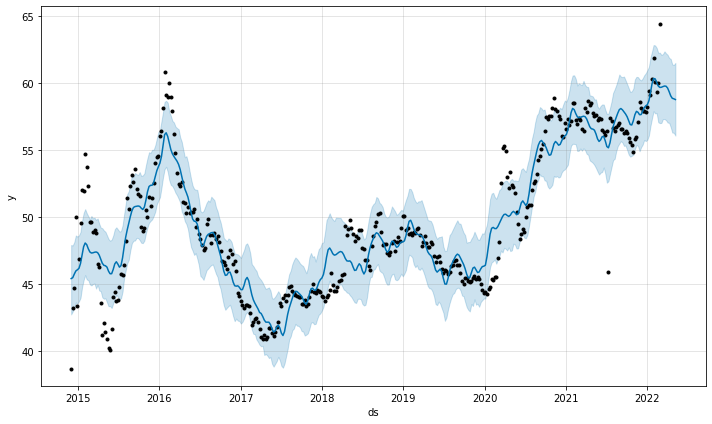

In [ ]:
fig1a = model_Prophet1.plot(forecast1)

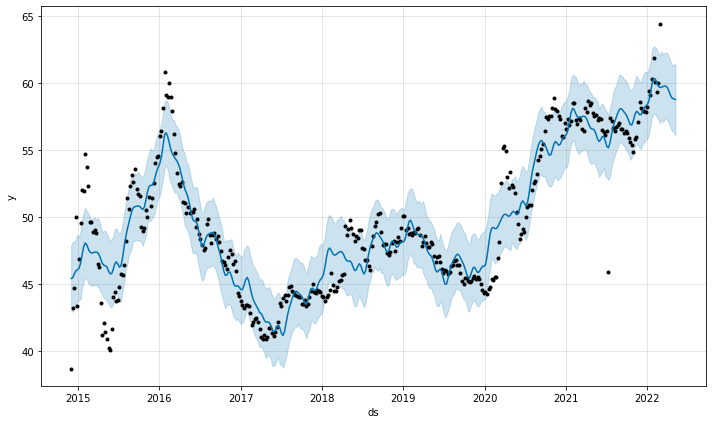

In [ ]:
fig1b = model_Prophet2.plot(forecast2)

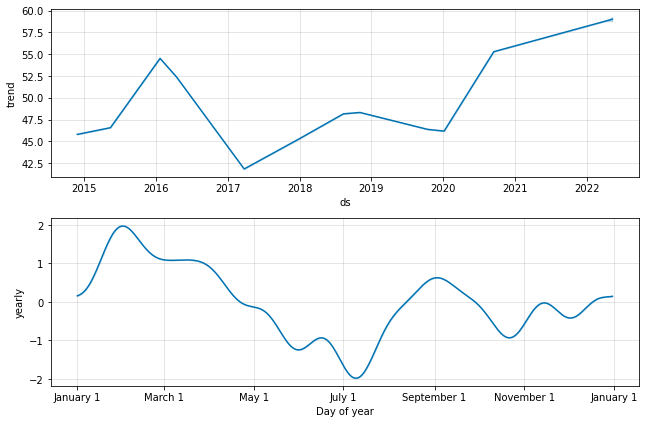

In [ ]:
fig2a = model_Prophet1.plot_components(forecast1)

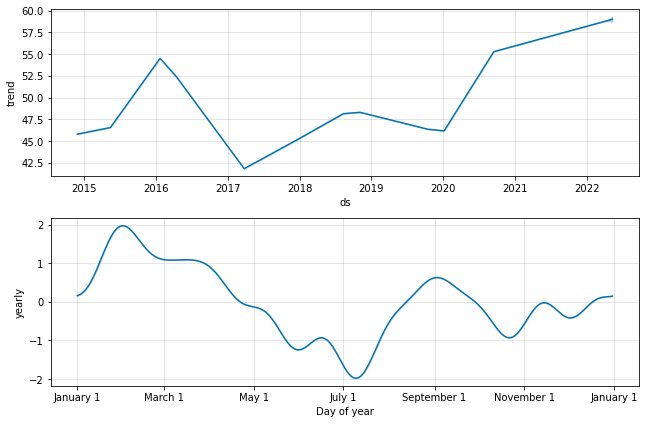

In [ ]:
fig2b = model_Prophet1.plot_components(forecast2)

In [ ]:
test_data['Predicted_Prophet1'] = forecast1[-(len(proph_test)):][['ds', 'yhat']].set_index('ds')
test_data['Predicted_Prophet2'] = forecast2[-(len(proph_test)):][['ds', 'yhat']].set_index('ds')

<AxesSubplot:xlabel='Date'>

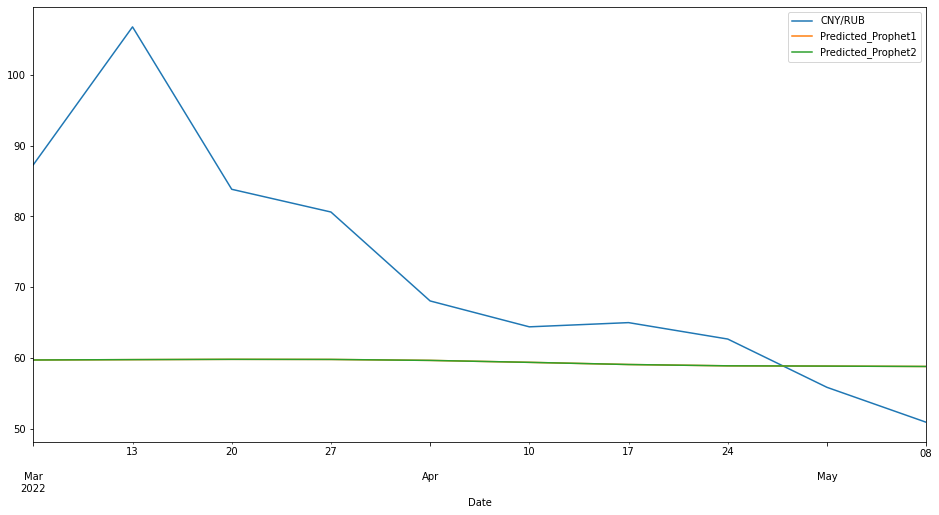

In [ ]:
test_data[[value_col, 'Predicted_Prophet1', 'Predicted_Prophet2']].plot(figsize=(16,8))

### Metrics

In [ ]:
timeseries_evaluation_metrics_func(test_data['CNY/RUB'], test_data.Predicted_ETS)

Evaluation metric results:-
Mean Square Error is : 328.8972486302147
Mean Absolute Error is : 13.01687956619205
Root Mean Square Error is : 18.135524492834904
Mean Absolute Percentage Error is : 15.968750087334369
R2 score is : -0.27759372877815336

Weighted MAPE: 0.17945188111471086


In [ ]:
timeseries_evaluation_metrics_func(test_data['CNY/RUB'], test_data.Predicted_ARIMA)

Evaluation metric results:-
Mean Square Error is : 334.43800846164754
Mean Absolute Error is : 13.317911907362548
Root Mean Square Error is : 18.287646334661208
Mean Absolute Percentage Error is : 16.716208800453796
R2 score is : -0.2991166817453377

Weighted MAPE: 0.183601940245604


In [ ]:
timeseries_evaluation_metrics_func(test_data['CNY/RUB'], test_data.Predicted_SARIMAX)

Evaluation metric results:-
Mean Square Error is : 308.8913313187909
Mean Absolute Error is : 13.247128041619401
Root Mean Square Error is : 17.575304586799938
Mean Absolute Percentage Error is : 17.080877617177638
R2 score is : -0.19988120730836645

Weighted MAPE: 0.18262610745898364


In [ ]:
timeseries_evaluation_metrics_func(test_data['CNY/RUB'], test_data.Predicted_Prophet1)

Evaluation metric results:-
Mean Square Error is : 420.6359555285979
Mean Absolute Error is : 15.3595626052841
Root Mean Square Error is : 20.50941138913055
Mean Absolute Percentage Error is : 18.641794135172557
R2 score is : -0.6339506065195266

Weighted MAPE: 0.2117483217541766


In [ ]:
timeseries_evaluation_metrics_func(test_data['CNY/RUB'], test_data.Predicted_Prophet2)

Evaluation metric results:-
Mean Square Error is : 420.6359555285979
Mean Absolute Error is : 15.3595626052841
Root Mean Square Error is : 20.50941138913055
Mean Absolute Percentage Error is : 18.641794135172557
R2 score is : -0.6339506065195266

Weighted MAPE: 0.2117483217541766


### Conclusion: 

Based on the WMAPE value, the ETS model provide the best prediction. But the R2 score for all predictions are negative so the predictions are not so reliable. 

Ranking for the models: ETS, ARIMA, SARIMAX, and Prophet